In [1]:
import sys
import os
from tqdm import tqdm #progress bar
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from IPython.display import display
import time

pd.options.display.max_columns = None
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns",None)
CURR_DIR = os.getcwd()
print(CURR_DIR)

C:\Users\magnu\Jupyterfiler\Aksjer17


In [2]:
class Magnus:
    def __init__(self): 
        self.from_date = datetime.today() - timedelta(days=30*12*5)  
        self.to_date = datetime.today()
        self.ri_sma1 = 50  
        self.ri_sma2 = 20  
        self.ri_rsi = 14   
        self.rsi_ema_bool = True #True: Use exponential moving average in RSI. False: Use simple moving average  in RSI
        self.ri_std = self.ri_rsi 
        self.bollinger_factor = 2
        self.ri_sma_vol = 1 
        self.scaled_boolean = False
        self.date = "Date"
        self.close = "Close"
        self.volume = "Volume"
        self.figure_hight_ratios_list = [5,2,2,1] 
    
    def get_name_symbol_df_from_file(self, name_symbol_csv_file_name, print_boolean):
        df = pd.DataFrame(None)
        df = pd.read_csv(CURR_DIR+"/"+name_symbol_csv_file_name)
        if print_boolean == True:
            display(df)
        return df
    
    def get_name_symbol_df_from_file_sort_and_save(self, name_symbol_csv_file_name, print_boolean):
        df = pd.DataFrame(None)
        df = pd.read_csv(CURR_DIR+"/"+name_symbol_csv_file_name)
        df.sort_values(by=['Name'],inplace=True)
        df.to_csv(CURR_DIR+"/"+name_symbol_csv_file_name, index=False)
        if print_boolean == True:
            display(df)
        return df
    
    def make_name_symbol_file(self, list_int, name_symbol_df_ob, write_to_file,name_symbol_csv_file_name):
        df = pd.DataFrame(columns=["Name", "Symbol"])
        for i, j in enumerate(list_int):
            df.loc[i] = [name_symbol_df_ob["Name"].iloc[j], name_symbol_df_ob["Symbol"].iloc[j]]
        if write_to_file == True:
             df.to_csv(CURR_DIR+"/"+name_symbol_csv_file_name, index=False)
        display(df)
            
    
    def get_df_list_from_yahoo(self, name_symbol_df, print_boolean):     #Henter fra Yahoo Finance
        df_list = []
        df_length = len(name_symbol_df)
        for i, symbol in enumerate(name_symbol_df["Symbol"]):  
            df=pd.DataFrame(None)
            df = yf.download(symbol+".OL", progress=False , period="max", parse_dates=True)
            df = df.reset_index()
            df["Date"] = pd.to_datetime(df["Date"])
            df_list.append([symbol,name_symbol_df["Name"].iloc[i],df])
            if print_boolean == True:
                print(i, name_symbol_df["Name"].iloc[i], symbol, df_length-i)
        return df_list
    
    def display_df_list(self, df_list, n_int):
        for i in range(0,len(df_list)):
            print(df_list[i][1]+" / "+df_list[i][0])
            display(pd.concat([df_list[i][2].head(n_int), df_list[i][2].tail(n_int)]))
    
    def set_from_date(self, from_date, input_time_is_datetime_objent_not_string):
        """ Example: val_str = 2021-01-01 , %Y-%m-%d """
        if input_time_is_datetime_objent_not_string == False:
            self.from_date = datetime.fromisoformat(from_date)
        else:
            self.from_date = from_date
            
    def set_to_date(self, to_date, input_time_is_datetime_objent_not_string):
        """ Example: val_str = 2020-01-01 , %Y-%m-%d """
        if input_time_is_datetime_objent_not_string == False:
            self.to_date = datetime.fromisoformat(to_date)
        else:
            self.to_date = to_date
            
    def set_scaled_boolean(self, scaled_boolean):
        self.scaled_boolean = scaled_boolean
    
    # CALCULATIONS 
    
    def calc_one(self, df):
        self.calc_sma_bollinger(df)
        self.calc_sma_volume(df)
        self.calc_rsi(df)
        self.calc_delta_sma(df)
        
    def calc_all(self, df_list,name_symbol_file):
        for i in range(0,len(df_list)):
            self.calc_one(df_list[i][2])
        print("Done: "+name_symbol_file)
 
    def calc_sma_bollinger(self, df):
        """ Dataframe calculations: Simple rolling average and bollinger band """
        if self.scaled_boolean == True:
            first_price = df[self.close][(df[self.date] >= self.from_date) & (df[self.date] <= self.to_date)].iloc[0]
            df[self.close]=df[self.close].divide(first_price)
        
        df['SMA_{}'.format(self.ri_sma1)] = df[self.close].rolling(window=self.ri_sma1).mean()
        df['SMA_{}'.format(self.ri_sma2)] = df[self.close].rolling(window=self.ri_sma2).mean()
        # Dataframe calculations: Standard Deviation 
        df['STD_{}'.format(self.ri_std)] = df[self.close].rolling(window=self.ri_std).std()
        # Dataframe calculationr: Bollinger Band
        df['BOLLINGER_TOP_{}'.format(self.ri_std)] = df['SMA_{}'.format(self.ri_sma2)]+df['STD_{}'.format(self.ri_std)].multiply(self.bollinger_factor)
        df['BOLLINGER_BTM_{}'.format(self.ri_std)] = df['SMA_{}'.format(self.ri_sma2)]-df['STD_{}'.format(self.ri_std)].multiply(self.bollinger_factor)

    def calc_rsi(self,df):
        """ Returns a pd.Series with the relative strength index. """
        delta = df[self.close].diff()  
        periods = self.ri_rsi
        ema_bool = self.rsi_ema_bool
        # Make two series: one for lower closes and one for higher closes
        up = delta.clip(lower=0)
        down = -1 * delta.clip(upper=0)
        if ema_bool == True:
            # Use exponential moving average
            ma_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
            ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
        else:
            # Use simple moving average
            ma_up = up.rolling(window = periods).mean()
            ma_down = down.rolling(window = periods).mean()
        rsi = ma_up / ma_down
        rsi = 100 - (100/(1 + rsi))
        df["rsi_{}".format(self.ri_rsi)] = rsi    
    
    def calc_sma_volume(self,df):
        """ Calculate simple moving average volume """
        df["Volume_SMA_{}".format(self.ri_sma_vol)] = df[self.volume].rolling(window=self.ri_sma_vol).mean()

    def calc_delta_sma(self,df):
        """  Difference between SMA 1 and SMA 2 """
        delta_str = "DELTA_SMA_{str2}-{str1}".format(str2=self.ri_sma2, str1=self.ri_sma1)
        sma1_str = "SMA_{}".format(self.ri_sma1)
        sma2_str = "SMA_{}".format(self.ri_sma2)
        delta_str_positive = "DELTA_SMA_{str2}-{str1}_POSITIVE".format(str2=self.ri_sma2, str1=self.ri_sma1)
        delta_str_negative = "DELTA_SMA_{str2}-{str1}_NEGATIVE".format(str2=self.ri_sma2, str1=self.ri_sma1)
        df[delta_str]=df[sma2_str]-df[sma1_str]
        df[delta_str_positive] = np.where(df[delta_str]<0,np.nan,df[delta_str]) #np.where(condition, if true, if false)
        df[delta_str_negative] = np.where(df[delta_str]>0,np.nan,df[delta_str].multiply(-1))
        
    def set_figure_hight_ratios_list(self,figure_hight_ratios_list):
        self.figure_hight_ratios_list = figure_hight_ratios_list

    def plot_all_graphs(self,df_list):
        for i in range(0,len(df_list)):
            self.plot_one_graph(df_list[i],i)
    
    def plot_one_graph(self, df_list_i,i):
        df = pd.DataFrame(None)
        temp_df =pd.DataFrame(None)
        name = df_list_i[0] 
        symbol = df_list_i[1]
        df = df_list_i[2]  

        temp_df = df[(df[self.date] >= self.from_date) & (df[self.date] <= self.to_date)]
        SMA1 = 'SMA_{}'.format(self.ri_sma1)
        SMA2 = 'SMA_{}'.format(self.ri_sma2)
        BOLLINGER_TOP = 'BOLLINGER_TOP_{}'.format(self.ri_std)
        BOLLINGER_BTM = 'BOLLINGER_BTM_{}'.format(self.ri_std)
        
        # Creating subplots and ratioes 
        fig, (ax_sma_bollinger, ax_rsi, ax_delta_sma_std, ax_vol) = plt.subplots(4,gridspec_kw={'height_ratios': self.figure_hight_ratios_list})
        
        # Xlim and Ylim 
        ax_sma_bollinger.set_xlim(self.from_date, self.to_date)
        ax_rsi.set_xlim(self.from_date, self.to_date)
        ax_rsi.set_ylim(10, 90)
        ax_delta_sma_std.set_xlim(self.from_date, self.to_date)
        ax_vol.set_xlim(self.from_date, self.to_date)
        
        # Plot
        ax_sma_bollinger.plot(self.date,self.close, data=temp_df,color='seagreen', linewidth=1)
        ax_sma_bollinger.plot(self.date,'SMA_{}'.format(self.ri_sma1), data=temp_df, color='red', linewidth=1)
        ax_sma_bollinger.plot(self.date,'SMA_{}'.format(self.ri_sma2), data=temp_df, color='blue', linewidth=1)
        ax_sma_bollinger.plot(self.date,'BOLLINGER_TOP_{}'.format(self.ri_std), data=temp_df, color='coral', linewidth=1)
        ax_sma_bollinger.plot(self.date,'BOLLINGER_BTM_{}'.format(self.ri_std), data=temp_df, color='coral', linewidth=1)
        ax_sma_bollinger.fill_between(self.date,'BOLLINGER_BTM_{}'.format(self.ri_std),'BOLLINGER_TOP_{}'.format(self.ri_std), data = temp_df, facecolor='g', alpha=0.05)
        ax_rsi.plot(self.date, "rsi_{}".format(self.ri_rsi), data=temp_df, color="red", linewidth=1)
        ax_rsi.axhline(y = 70, color = 'gray', linestyle = '-')
        ax_rsi.axhline(y = 50, color = 'gray', linestyle = '-')
        ax_rsi.axhline(y = 30, color = 'gray', linestyle = '-')
        #ax_vol.bar(self.date,"{}( volume )".format(self.close),data=temp_df,color="skyblue")
        ax_vol.bar(self.date,self.volume,data=temp_df,color="skyblue")
        ax_delta_sma_std.plot(self.date,'STD_{}'.format(self.ri_std), data=temp_df, color="coral")
        ax_delta_sma_std.plot(self.date,"DELTA_SMA_{str2}-{str1}_POSITIVE".format(str2=self.ri_sma2, str1=self.ri_sma1),data=temp_df,color="blue")
        ax_delta_sma_std.plot(self.date,"DELTA_SMA_{str2}-{str1}_NEGATIVE".format(str2=self.ri_sma2, str1=self.ri_sma1),data=temp_df,color="red")
        
        #Title
        fig.suptitle(str(i)+": "+name+" / "+symbol, fontsize=16)
        
        #Show legend
        l1 = "Closing price: "+name
        l2 = "Simple moving average ({})".format(self.ri_sma1)
        l3 = "Simple moving average ({})".format(self.ri_sma2)
        l4 = "BOLLINGER ({ri_std}). Price +/- {factor} times STD".format(ri_std=self.ri_std, factor=self.bollinger_factor)
        ax_sma_bollinger.legend([l1, l2, l3,l4])
        ax_rsi.legend(["Relative Strength Index ({})".format(self.ri_rsi)])
        ax_vol.legend(["Volume ({})".format(self.ri_sma_vol)]) 
        l10="SMA({str2}) - SMA({str1})".format(str2=self.ri_sma2, str1=self.ri_sma1)
        l11="SMA({str1}) - SMA({str2})".format(str2=self.ri_sma2, str1=self.ri_sma1)
        ax_delta_sma_std.legend(["Standard deviation ({})".format(self.ri_std),l10,l11])
        
        #Grid
        ax_sma_bollinger.grid()
        ax_sma_bollinger.minorticks_on()
        ax_sma_bollinger.grid(b=True, which='major', linestyle='-')
        ax_sma_bollinger.grid(b=True, which='minor', axis="x",linestyle='--')
        ax_rsi.grid()
        ax_rsi.minorticks_on()
        ax_rsi.grid(b=True, which='major', linestyle='-')
        ax_rsi.grid(b=True, which='minor', axis="x", linestyle='--')  
        #ax_std.grid()
        #ax_std.minorticks_on()
        #ax_std.grid(b=True, which='major', linestyle='-')
        #ax_std.grid(b=True, which='minor',axis="x", linestyle='-')
        ax_delta_sma_std.grid()
        ax_delta_sma_std.minorticks_on()
        ax_delta_sma_std.grid(b=True, which='major', linestyle='-')
        ax_delta_sma_std.grid(b=True, which='minor',axis="x", linestyle='-')
        ax_vol.grid()
        #ax_vol.minorticks_on()
        #ax_vol.grid(b=True, which='major', linestyle='-')
        #ax_vol.grid(b=True, which='minor',axis="x", linestyle='-')
           

In [8]:
name_symbol_df_ob = pd.DataFrame(None)
name_symbol_df = pd.DataFrame(None)

magnus = Magnus()

name_symbol_file = "kandidater.csv"
#name_symbol_file = "portifolio.csv"
#name_symbol_file = "eiendom.csv"
#name_symbol_file = "energi.csv"
#name_symbol_file = "luksus.csv"
#name_symbol_file = "stapels.csv"
#name_symbol_file = "teknologi.csv"
#name_symbol_file = "tele.csv"
#name_symbol_file = "utilities.csv"
#name_symbol_file = "finans.csv"
#name_symbol_file = "helse.csv"
#name_symbol_file = "basicmaterials.csv"
#name_symbol_file = "industri.csv"
#name_symbol_file = "basicmaterials.csv"
#name_symbol_file = "oslo_bors.csv"

#name_symbol_df_ob = magnus.get_name_symbol_df_from_file("oslo_bors.csv", print_boolean=False)
name_symbol_df = magnus.get_name_symbol_df_from_file_sort_and_save(name_symbol_file, print_boolean=False)

In [10]:
df_list_ob = []
df_list = []

#df_list_ob=magnus.get_df_list_from_yahoo(name_symbol_df_ob, print_boolean=False)
df_list=magnus.get_df_list_from_yahoo(name_symbol_df, print_boolean=True)

0 AKER CARBON CAPTUR ACC 12
1 AKER CLEAN HYDROGE ACH 11
2 AKER HORIZONS AKH 10
3 AKER OFFSHORE WIND AOW 9
4 AKER SOLUTIONS AKSO 8
5 ARENDALS FOSSEKOMP AFK 7
6 DLT DLTX 6
7 OBSERVE MEDICAL OBSRV 5
8 OTOVO OTOVO 4
9 PYRUM INNOVATIONS PYRUM 3
10 SATS SATS 2

1 Failed download:
- SOLON.OL: No data found, symbol may be delisted
11 SOLON EIENDOM SOLON 1


In [11]:
magnus.set_from_date(datetime.today() - timedelta(days=30*12) , input_time_is_datetime_objent_not_string = True)  #Set from_date for plots only (calculates indicators for all dates in dataframe)
magnus.set_to_date(datetime.today(), input_time_is_datetime_objent_not_string = True)                             #Set to_date for plots only (calculates indicators for all dates in dataframe)

magnus.set_scaled_boolean(False)  # If true: Divides ALL stock closeing prices on the stock price at the date "from_date". 

#magnus.calc_all(df_list_ob,"oslo_bors.csv")   # Calculates indicators for all stocks on oslo bors
magnus.calc_all(df_list,name_symbol_file)      # Calculates indicators for a selection of stocks

#magnus.display_df_list(df_list_ob,1)
#magnus.display_df_list(df_list,10)

Done: kandidater.csv


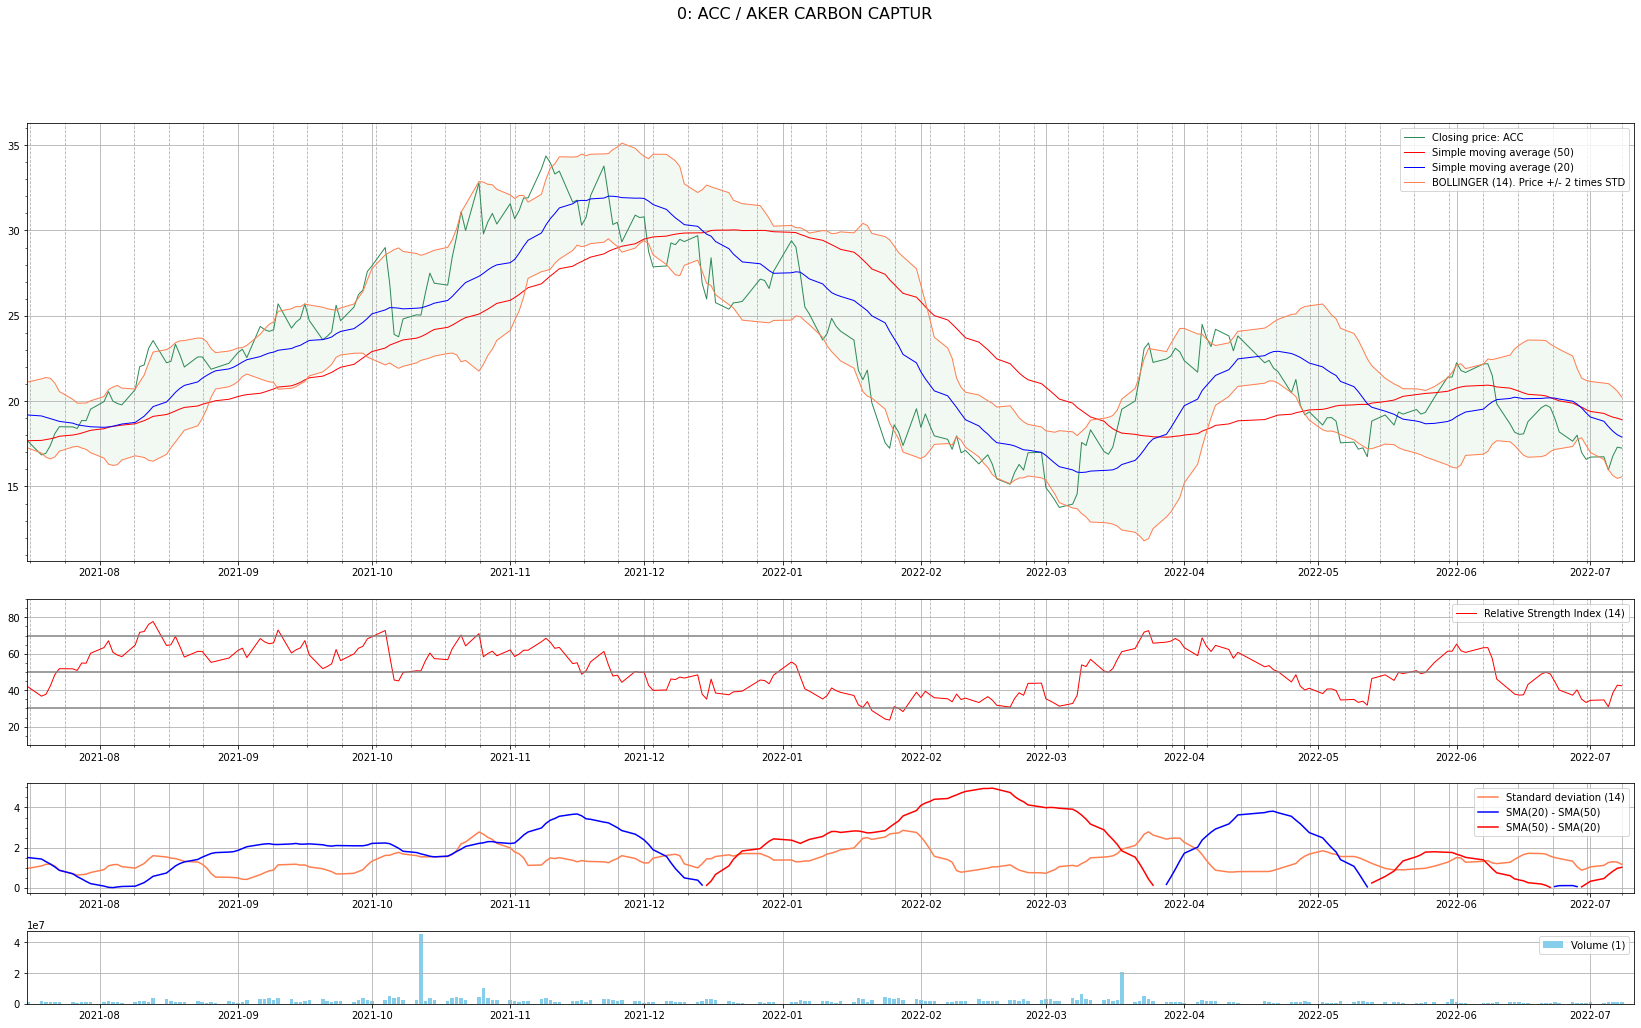

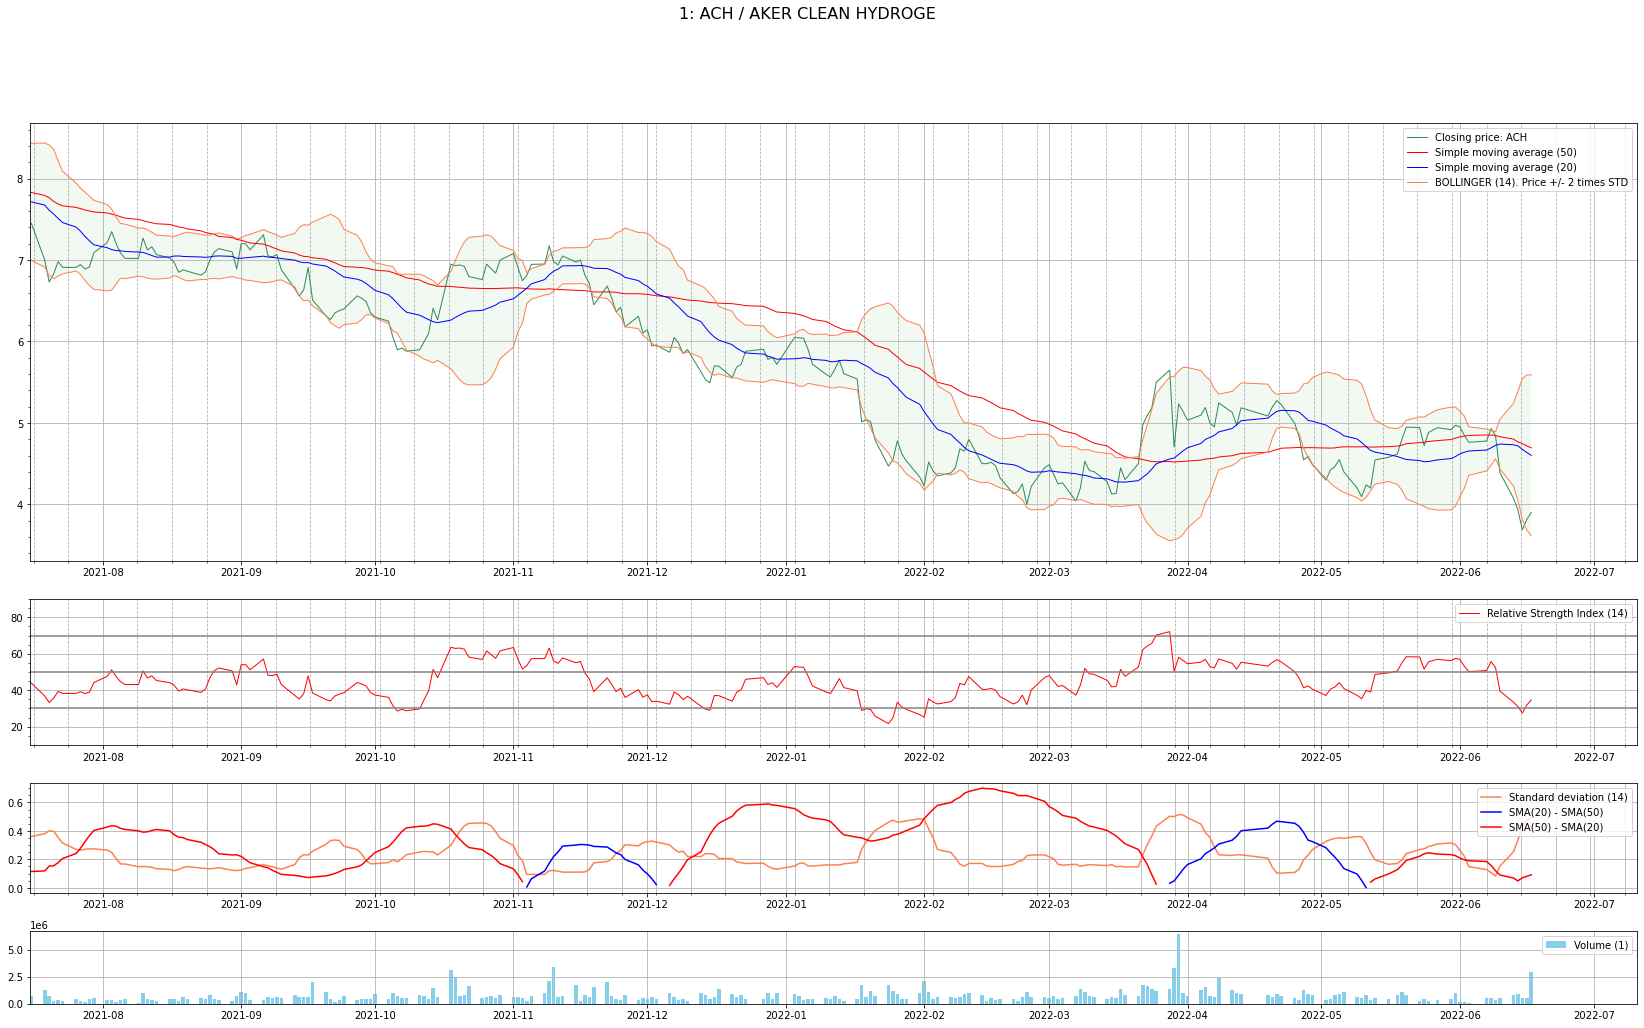

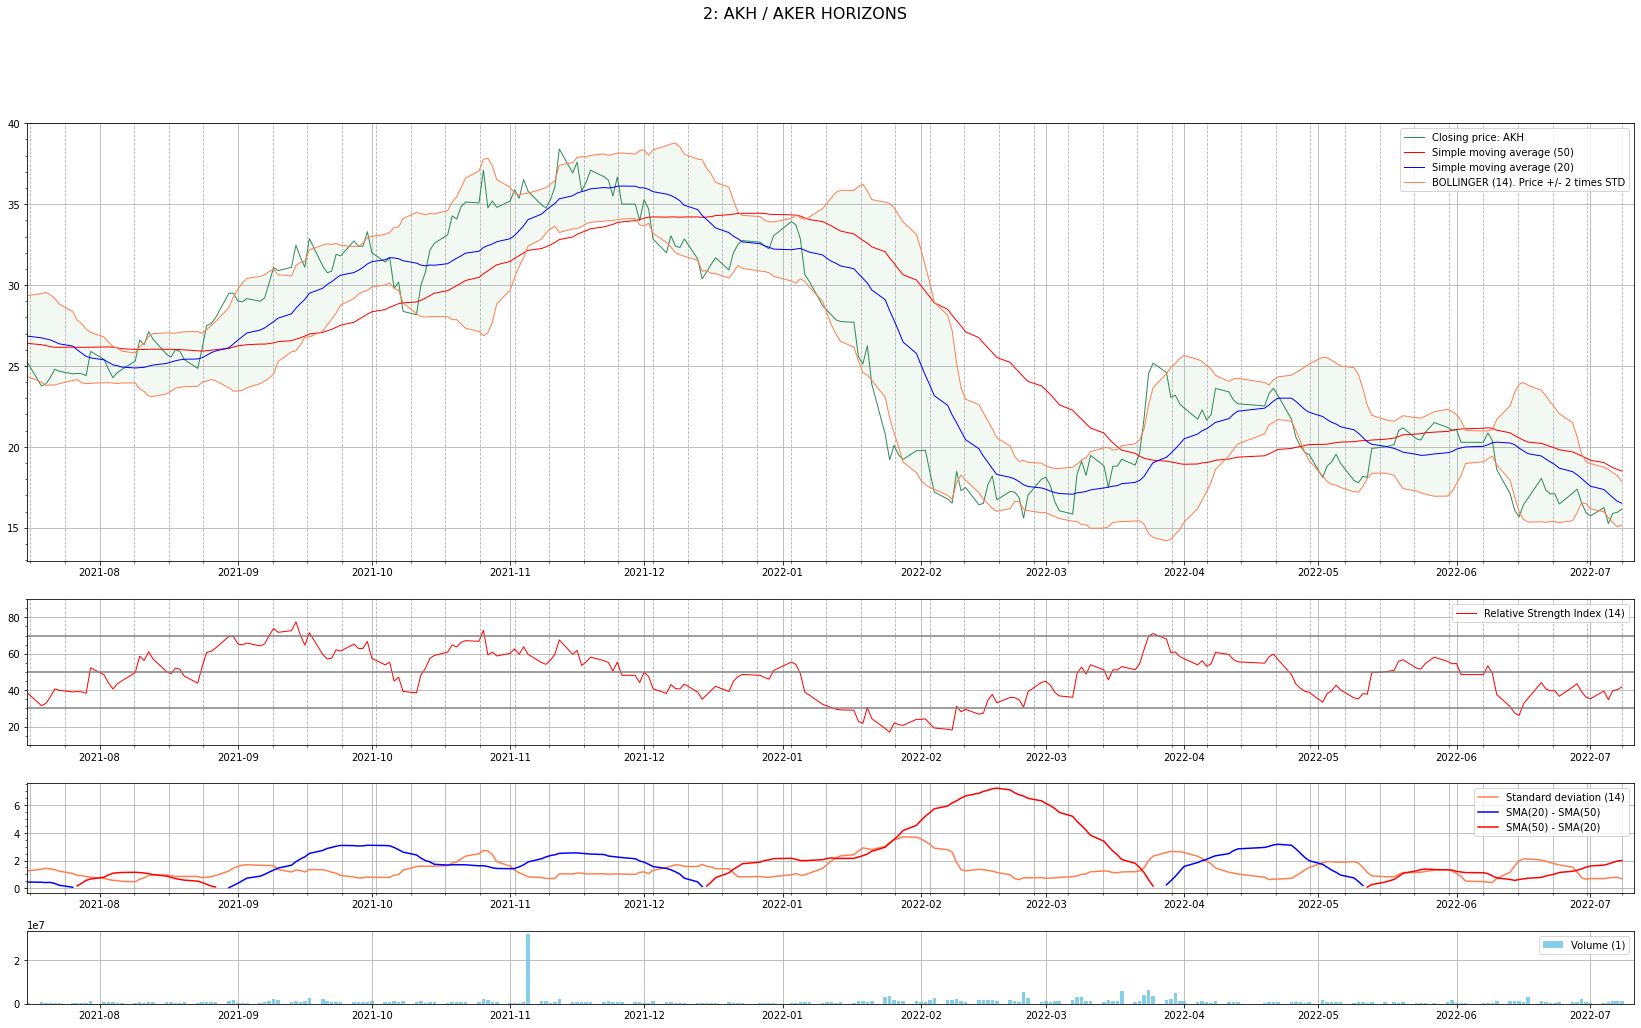

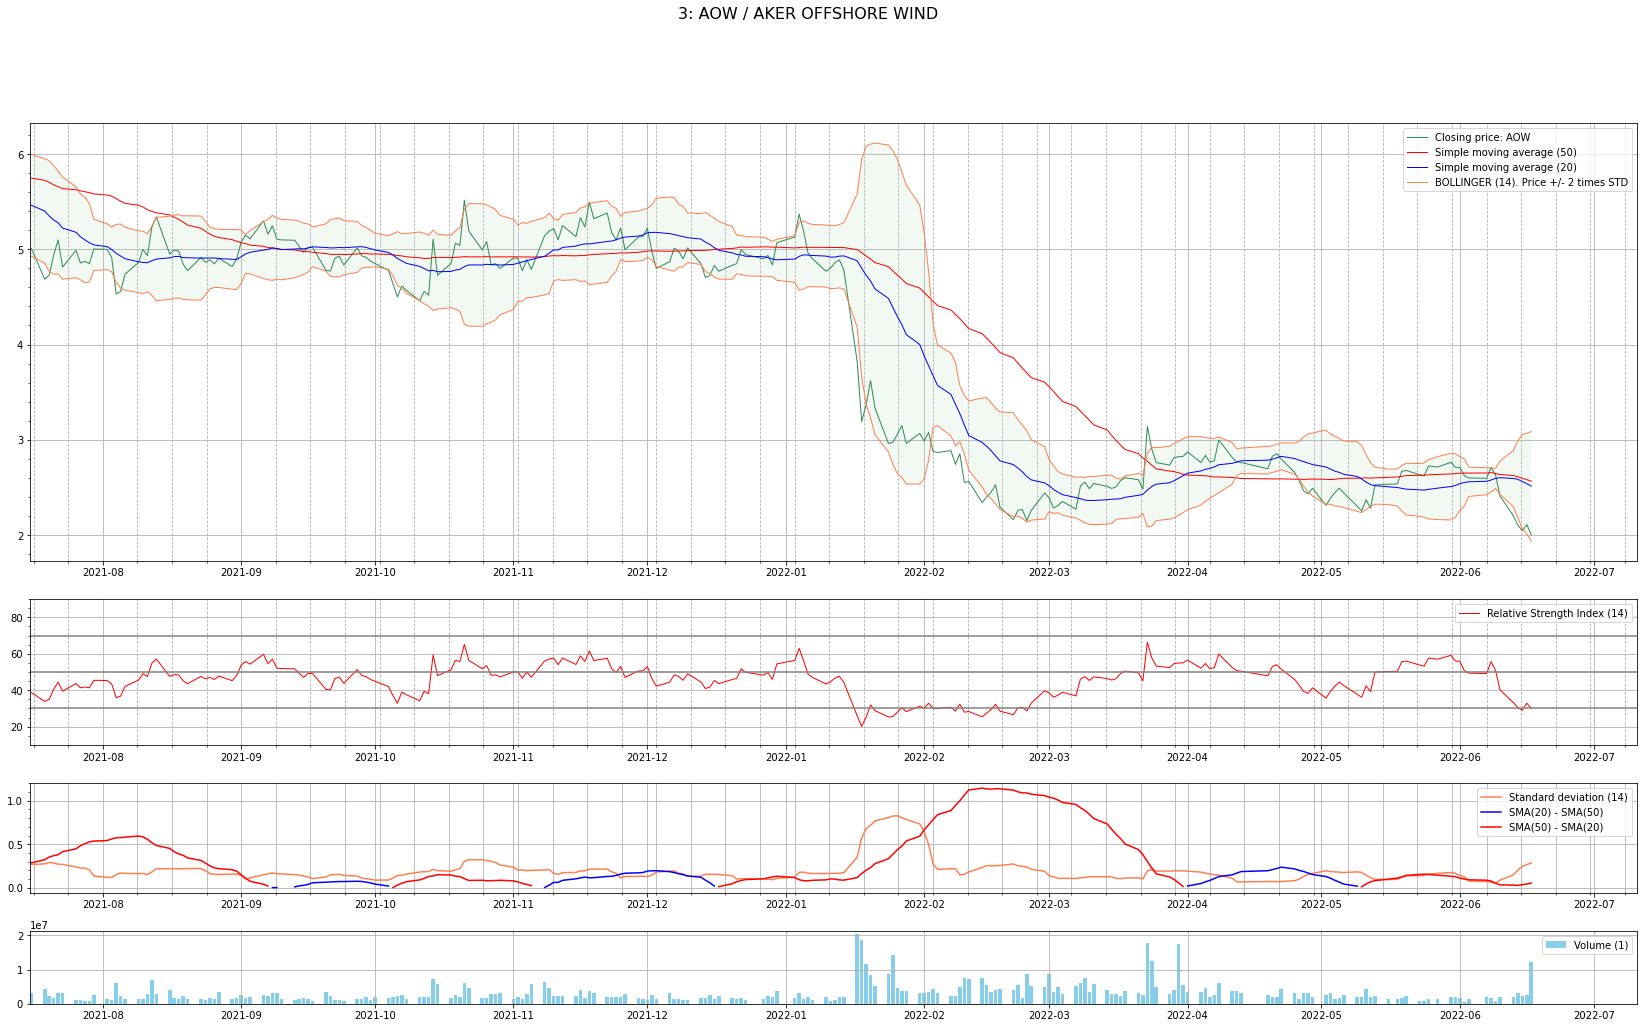

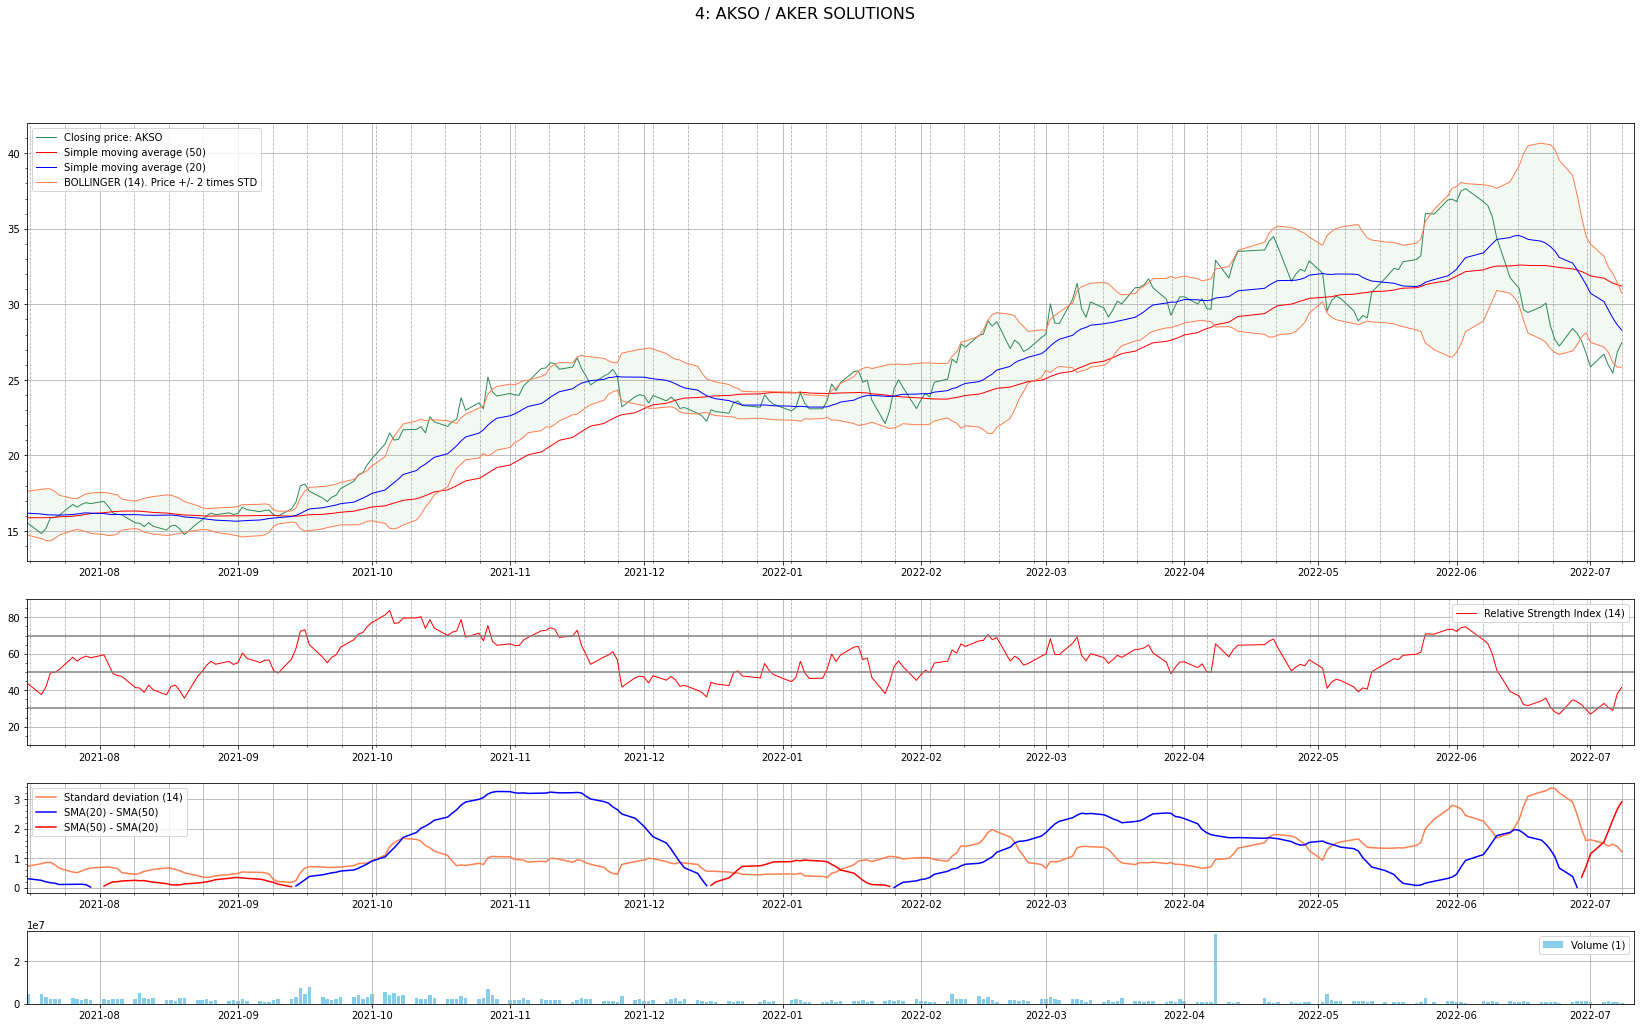

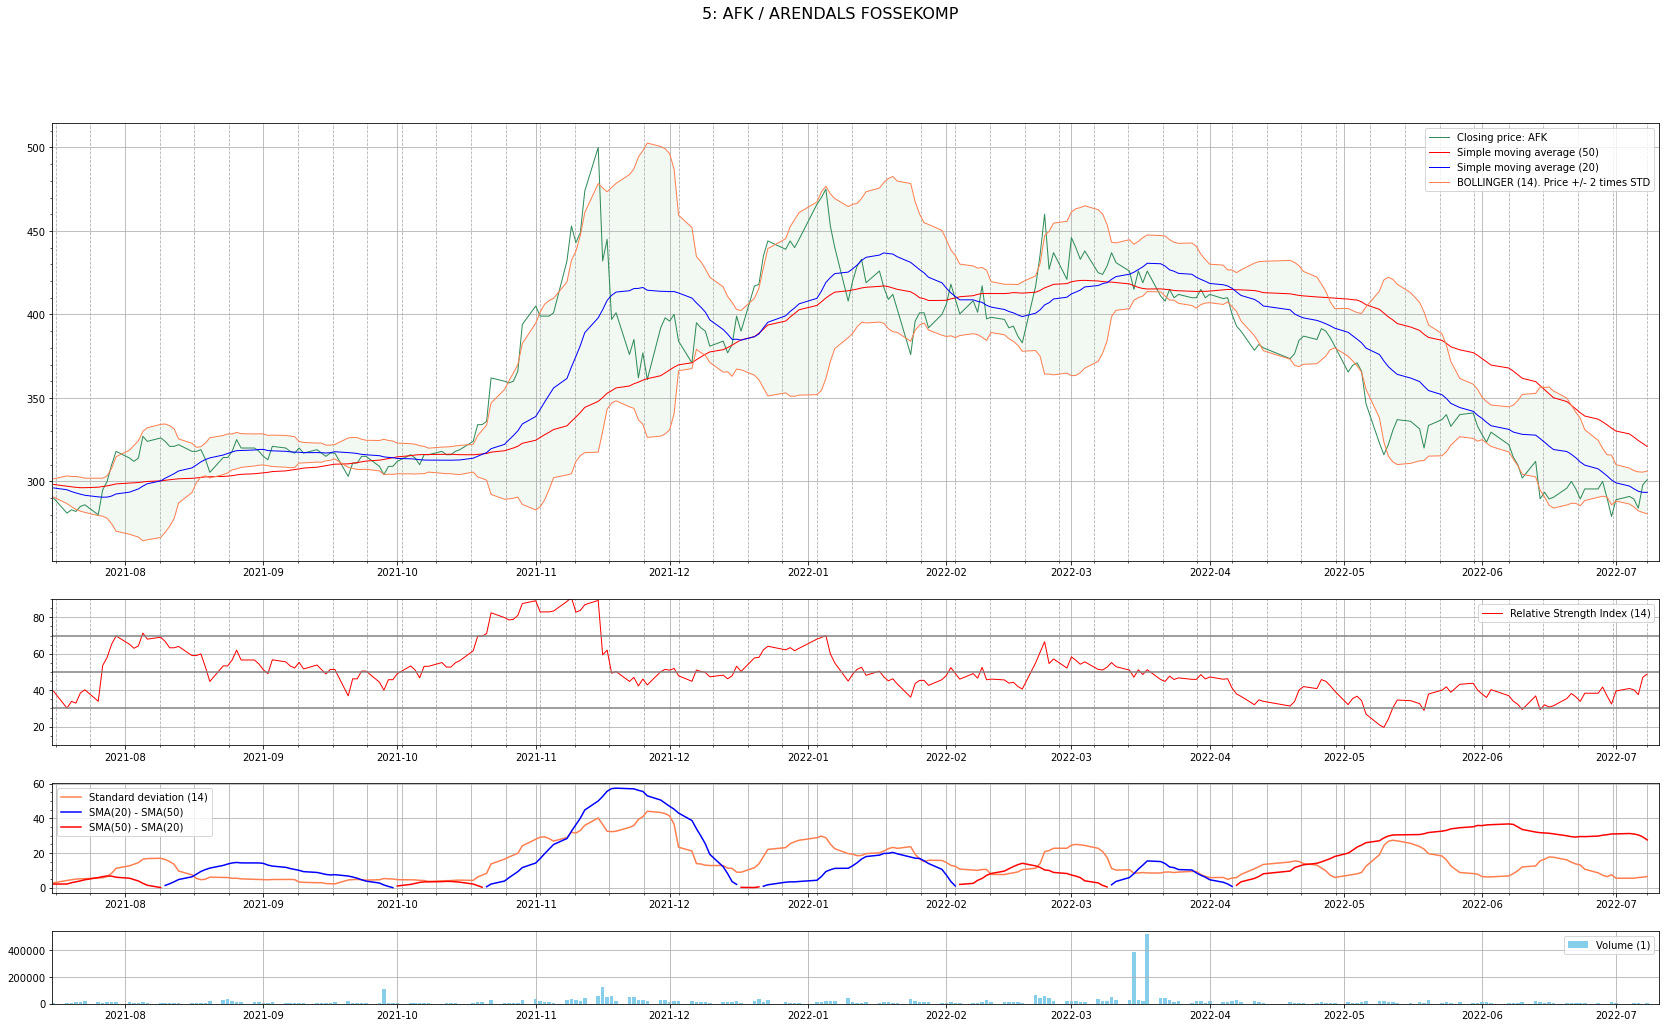

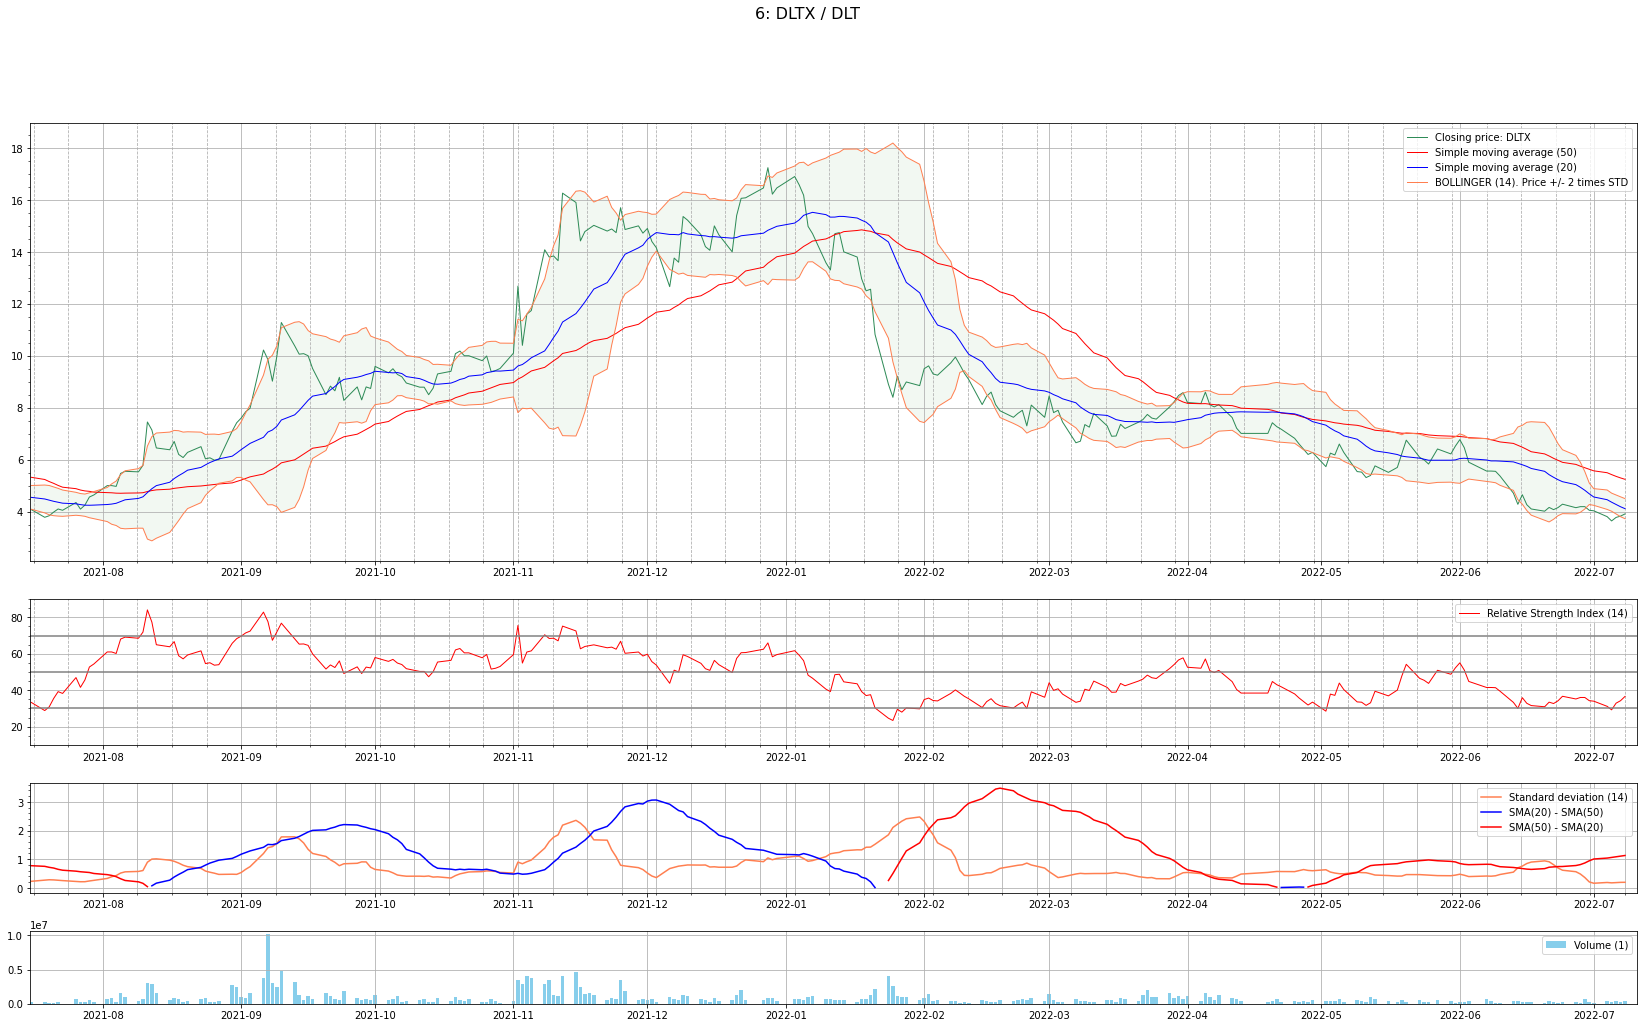

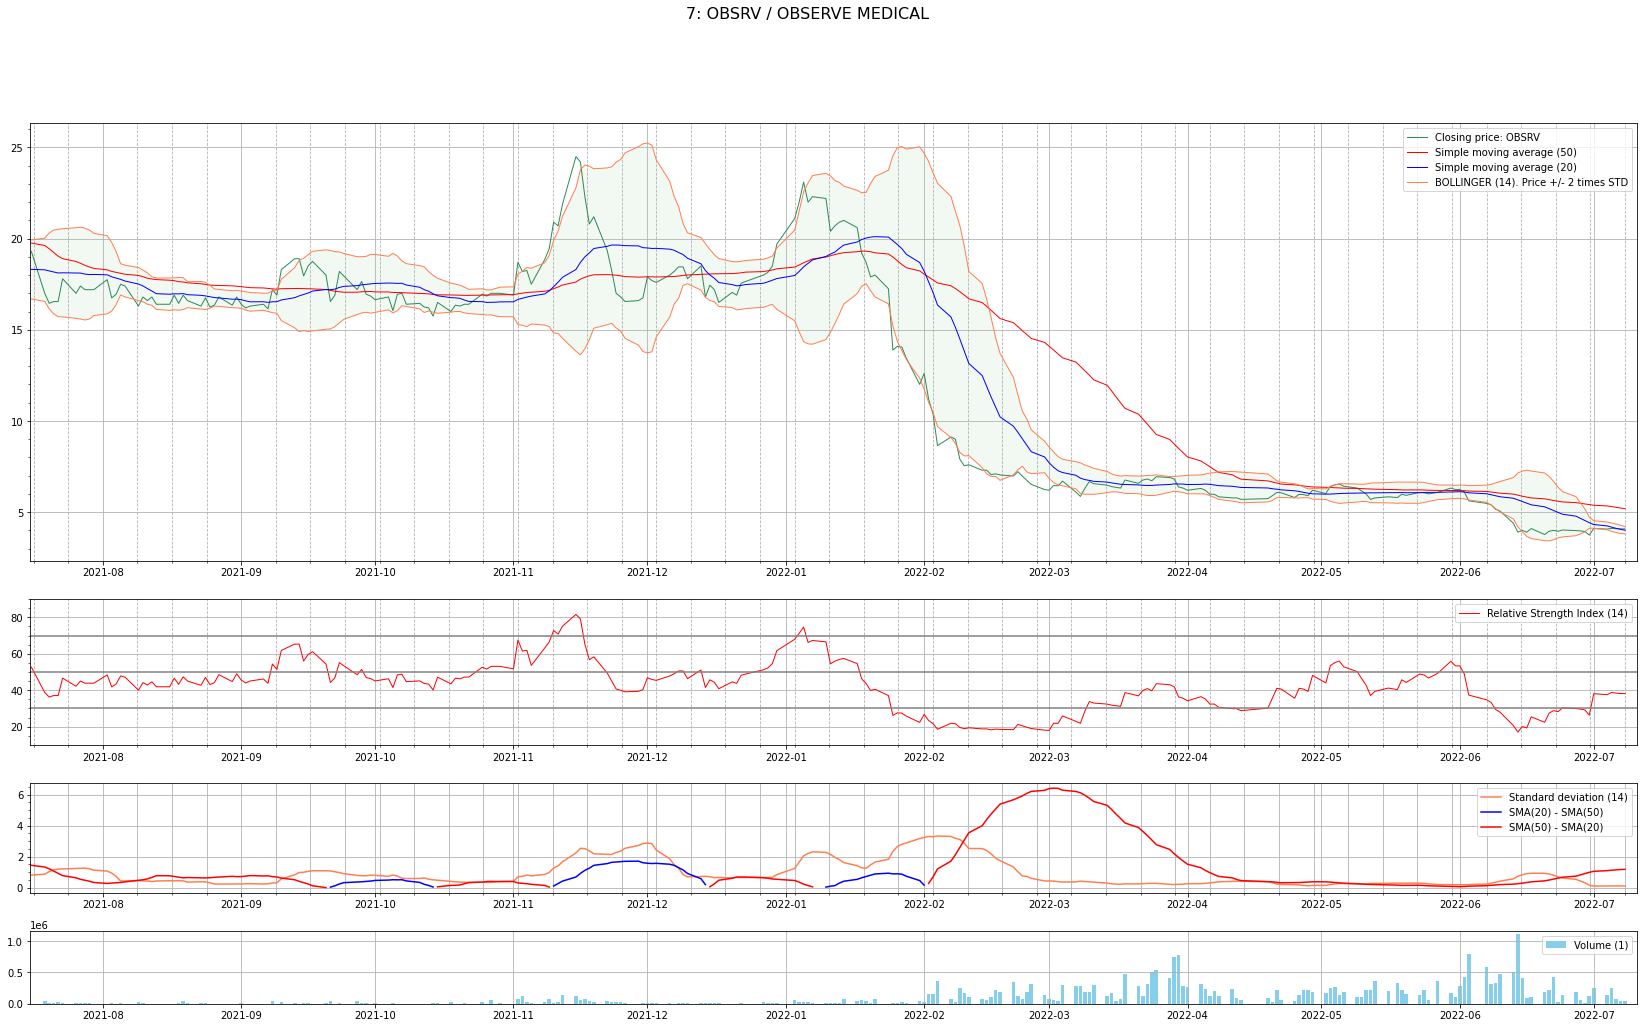

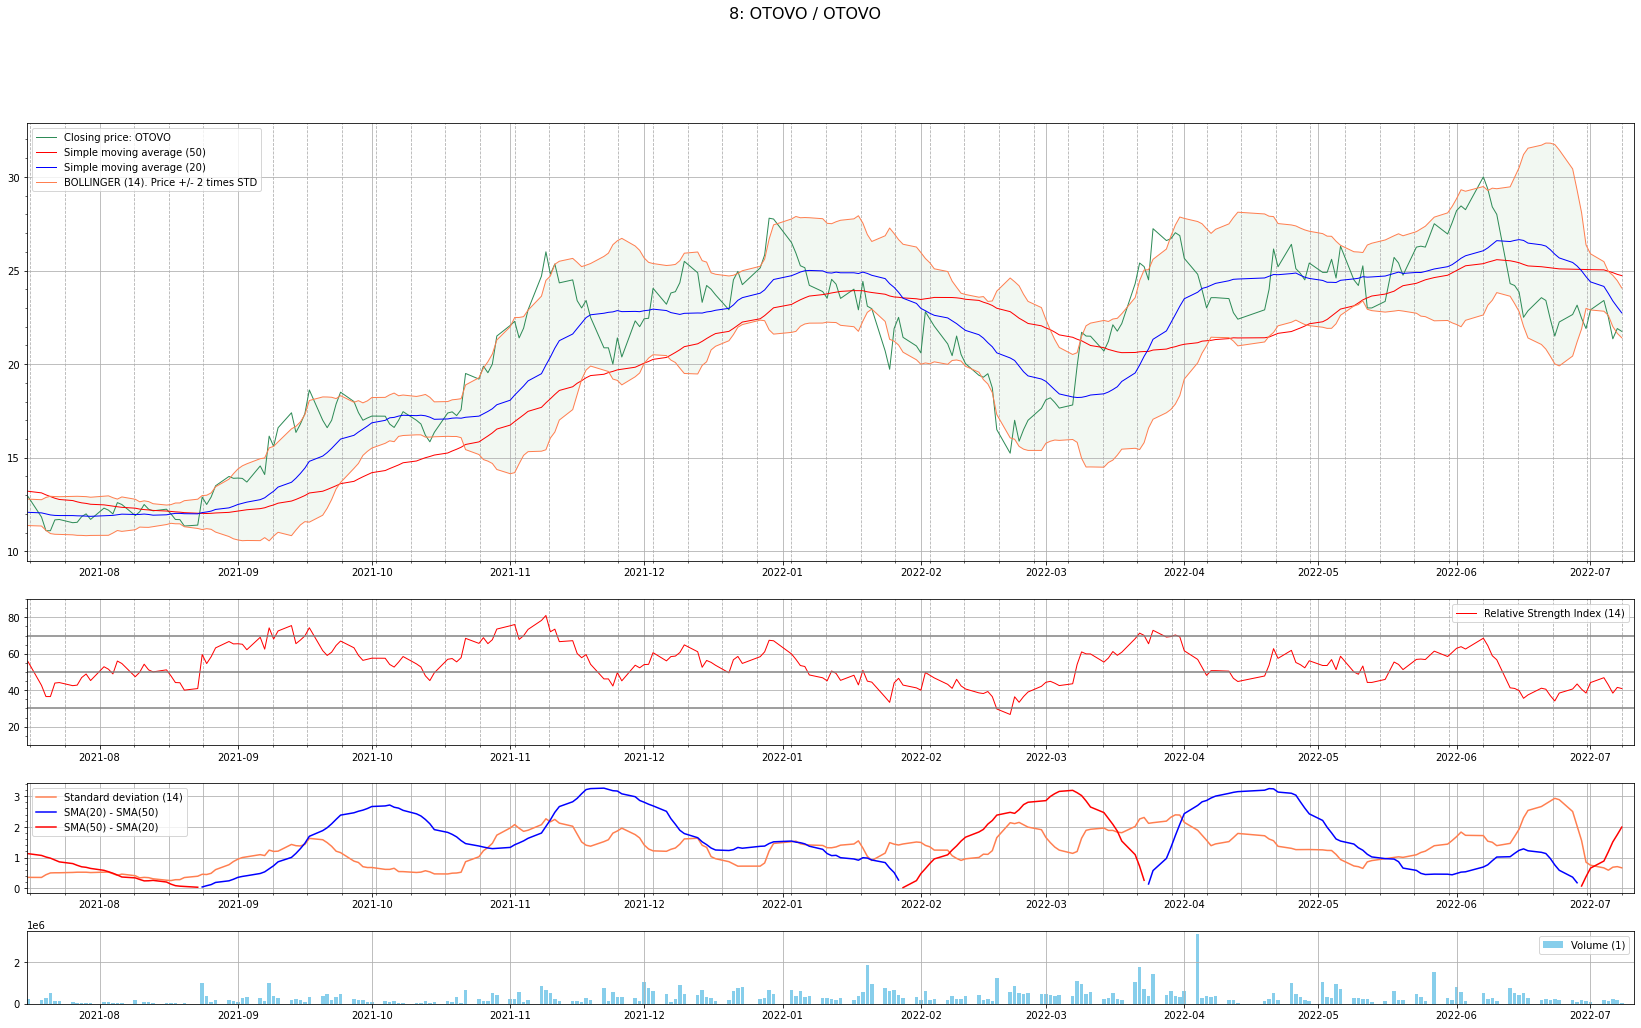

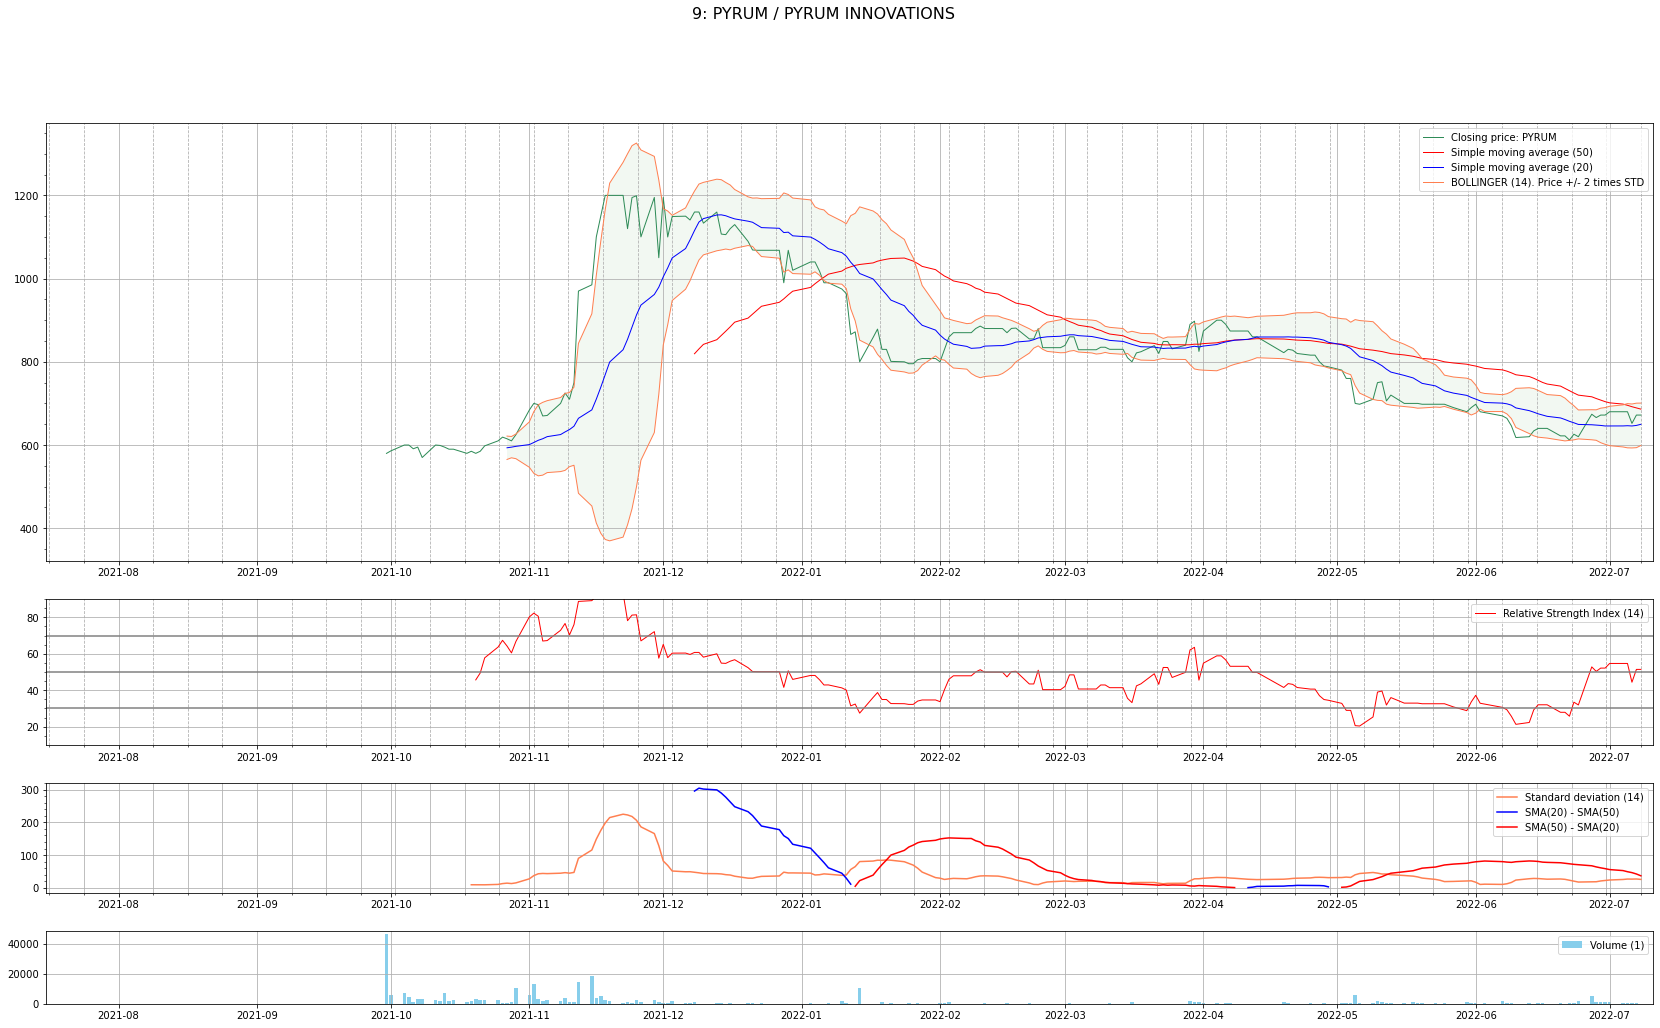

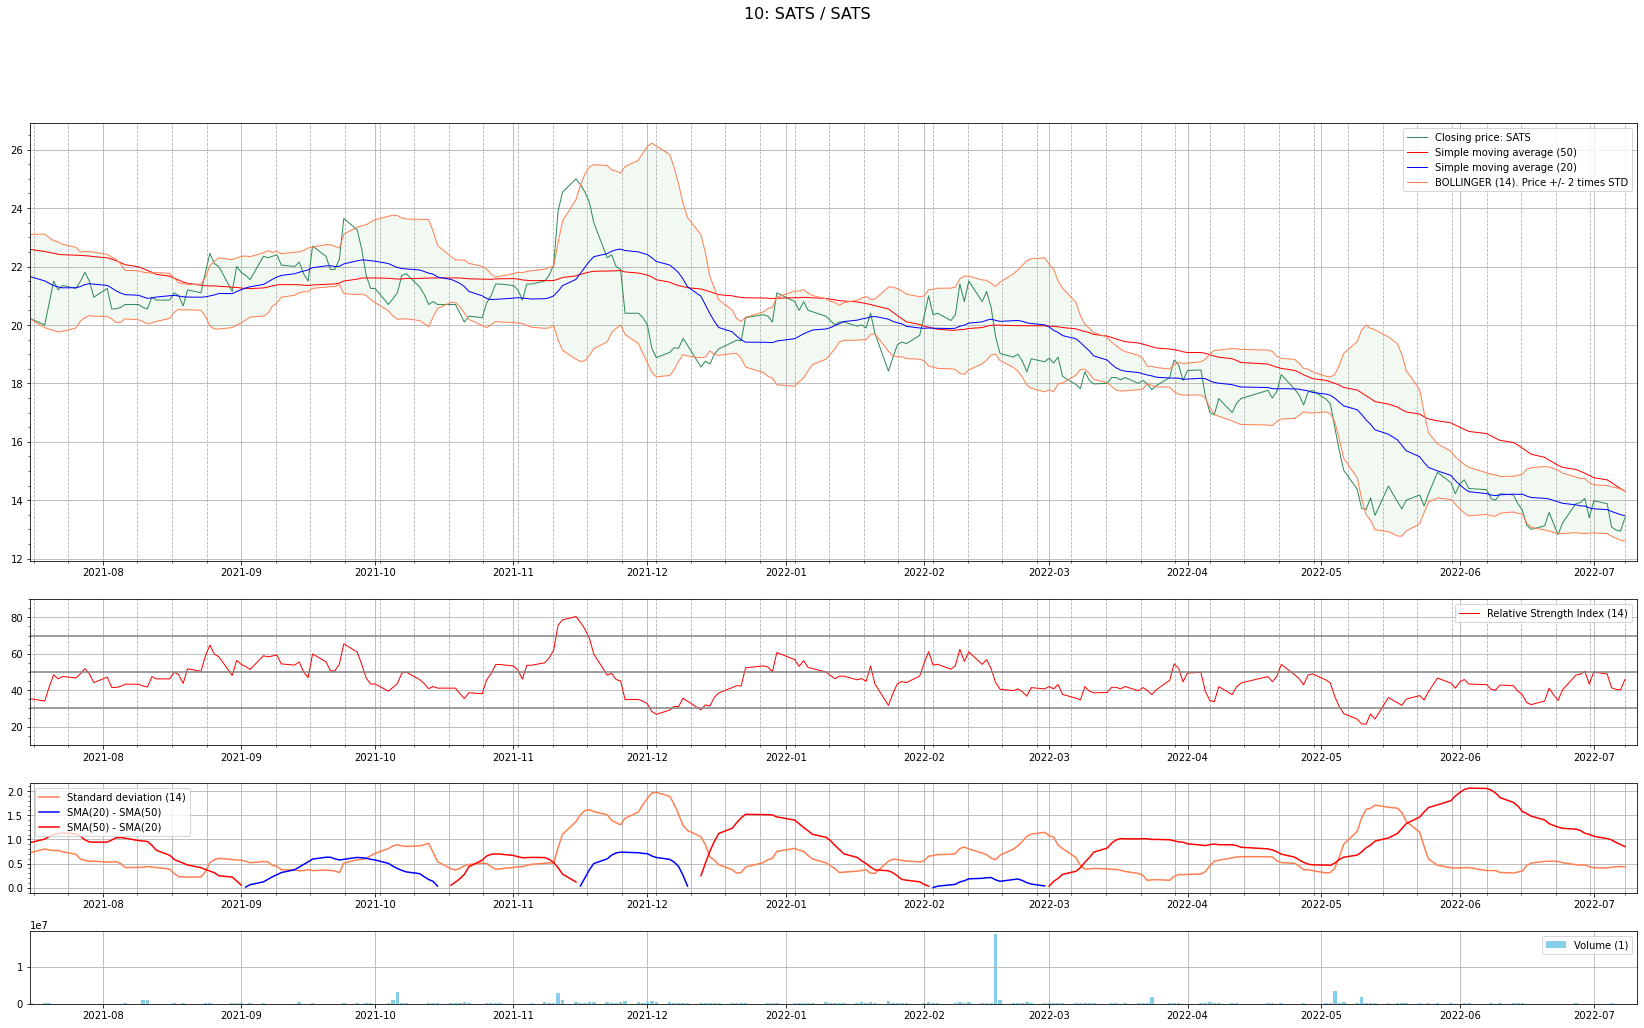

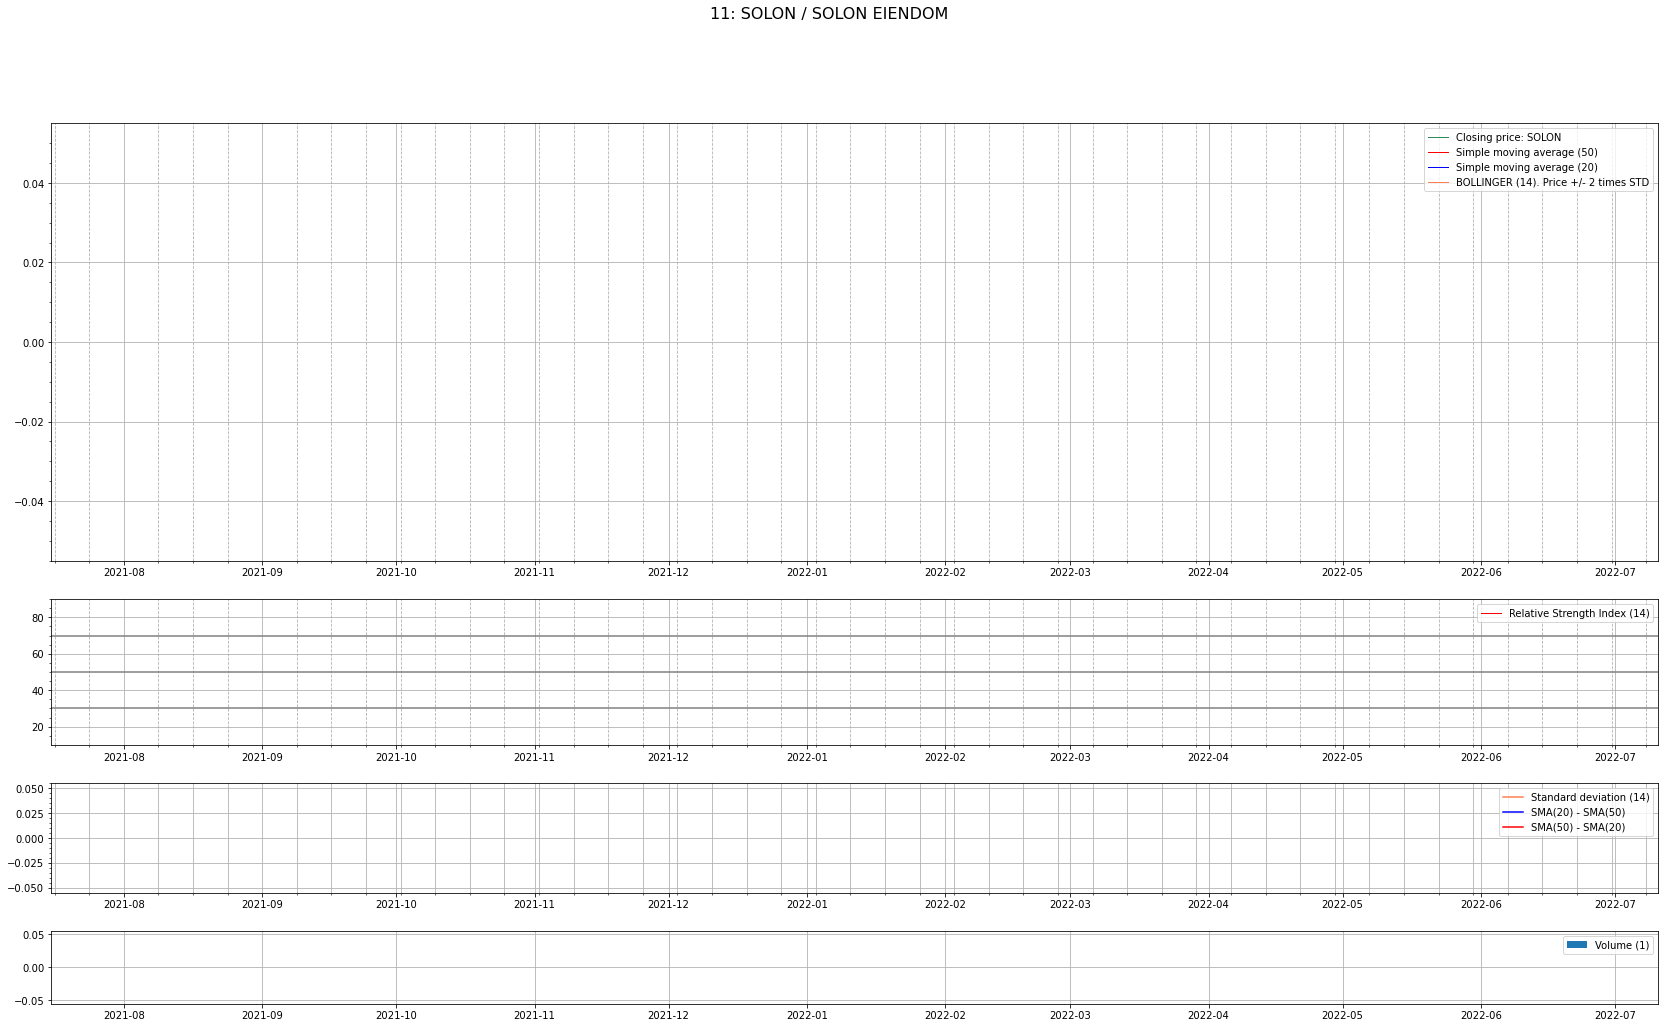

In [12]:
plt.close("all")
p=1.8 #Scaleing the size of the plot (16:9 ratio)
plt.rcParams['figure.figsize'] = [16*p,9*p]
magnus.set_figure_hight_ratios_list([6,2,1.5,1])  #The hight ratios of the subplots

#magnus.plot_all_graphs(df_list_ob)   # Plots all stocks on oslo bors
magnus.plot_all_graphs(df_list)       # Plots selection of stocks